# Análisis Exploratorio de Datos (EDA): 

## Objetivo
Este notebook contiene el análisis exploratorio completo del dataset, siguiendo una estructura organizada y metódica para entender los datos, limpiarlos y prepararlos para modelado.

## Contenido
1. Configuración Inicial y librearías
2. Carga y Vista General de los Datos
3. Limpieza y Preprocesamiento
4. Análisis Exploratorio de los Datos
5. Análisis estadístico
6. Análisis Univariante
7. Análisis Bivariante
8. Preprocesamiento de datos
9. Conclusiones

# 1. Configuración Inicial

Importamos las bibliotecas necesarias y configuramos el entorno de trabajo.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import os

### Configuración del estilo visual

In [ ]:
pd.set_option('display.max_rows', 100) 
pd.set_option('display.max_columns', None) 
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_rows', None)     # Show all rows
# pd.set_option('display.max_colwidth', None) # Show entire content of each column
pd.set_option('display.width', None)        # No limit on display width
pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping

In [69]:
# Setting paths
current_dir = os.getcwd()  # Use os.getcwd() to get the current working directory
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, "data")
file_path = os.path.join(data_dir, "")
cars_csv_path = os.path.join(data_dir, "train.csv")
#----------------------------------------------------------------------------------------------------
# Creading dataframes
df_car = pd.read_csv(cars_csv_path)

In [70]:
df_car.sample(5)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
114205,114205,Cadillac,Escalade ESV Platinum,2016,91600,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Beige,None reported,Yes,20399
46323,46323,Audi,RS 7 4.0T Performance Prestige,2019,18000,Gasoline,605.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Brown,None reported,Yes,96000
144231,144231,Volkswagen,CC 2.0T Sport,2016,123000,Gasoline,200.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,None reported,Yes,10995
138334,138334,Land,Rover Discovery Sport SE R-Dynamic,2020,14735,Gasoline,2.0 Liter,Automatic,Firenze Red,Black,None reported,NaN,16998
80920,80920,Lexus,RC 350 Base,2015,73948,Gasoline,306.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,34999


# 2. Carga y Preparación de los Datos

### Cargamos el dataset y realizamos una inspección inicial para entender su estructura.

In [35]:
# Setting paths
current_dir = os.getcwd()  # Use os.getcwd() to get the current working directory
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, "data")
file_path = os.path.join(data_dir, "")

car_csv_path = os.path.join(data_dir, "train.csv")
#----------------------------------------------------------------------------------------------------
# Creating dataframes
df_car_price= pd.read_csv(car_csv_path)

df_car_price.head()


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


### Vista general del dataset

In [36]:
df_car_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


# 3. Limpieza y Preprocesamiento

### Limpieza de Nombres de Columnas y Valores Faltantes

### Detección de duplicados

### Búsqueda de valores desconocidos

## Análisis de valores faltantes

En esta sección, analizamos los valores faltantes en el dataset para entender su distribución y decidir cómo manejarlos.

#### 1.Porcentaje de valores NaN por columna 
El porcentaje de valores `NaN` por columna nos ayuda a identificar qué variables tienen datos faltantes y en qué proporción. Esto es útil para decidir si debemos eliminar columnas, imputar valores o manejar los datos faltantes de otra manera.

### Porcentaje de NaN por país y por región

### Visualización de valores faltantes

En esta sección, utilizamos la biblioteca `missingno` para analizar los valores faltantes en el dataset. Estas visualizaciones nos ayudan a identificar patrones de valores faltantes y su relación con otras columnas.

#### 1. Matriz de valores faltantes
La matriz de valores faltantes muestra la presencia o ausencia de datos en cada columna. Esto es útil para identificar patrones de valores faltantes y su distribución en el dataset.

#### 2. Mapa de calor de correlación de nulidad
El mapa de calor de correlación de nulidad muestra la relación entre las columnas en términos de valores faltantes. Si dos columnas tienen una alta correlación de nulidad, significa que tienden a tener valores faltantes en los mismos registros.

### Análisis de valores faltantes en `Gov_Tax` por año

En esta sección, analizamos la frecuencia de valores faltantes (`NaN`) en la columna `Gov_Tax`, agrupados por año. Esto nos ayuda a identificar si los valores faltantes están concentrados en ciertos períodos de tiempo.

#### Análisis de NaN en 'Education_Campaign' por año

### Análisis de valores faltantes

### Imputación de valores faltantes

Justificación: 

### Eliminación de columnas redundantes. 
Investigar

#### Verificar la Redundancia con la Columna

#### Guardamos el nuevo csv

# 4 Análisis exploratorio de datos

### Distribución 

### Mapa de calor de correlaciones

En este análisis, generamos un mapa de calor para visualizar las correlaciones entre las variables numéricas del dataset.

### Relación entre variables numéricas

En este análisis, generamos un gráfico de pares para visualizar la relación entre todas las variables numéricas del dataset. Este gráfico nos permite identificar patrones, tendencias y posibles correlaciones entre las variables.

### Tendencia

### Relación

### Definición de la variable objetivo

Para este análisis, hemos decidido que la variable objetivo será

#### Justificación:
1. Es una variable

#### Tratamiento de la variable objetivo:
- Verificamos si hay valores faltantes en

# 5 Análisis estadístico

 ## Pruebas paramétricas
 ###   pruebas de normalidad

###   Kolmogorov-Simirnov

Hallazgos: 

 ### Shapiro-Wilk

Hallazgos: 

#### Visualización de la distribución: Gráfico Q-Q

### Prueba de Homegeneidad de varianza

Nos hemos decantado por Levene porque la prueba de Bartlett es más sensible a desviaciones de normalidad en los datos.

#### Levene

#### Generamos un boxplot para comparar visualmente las distribuciones de Diabetes_Prevalence entre los países

#### Prueba de ANOVA:
La prueba de ANOVA permitirá evaluar si las medias de diabetes_prevalence son significativamente diferentes entre los países

## 6. Análisis Univariante
### 6.1 Estadísticas Descriptivas
- Presentamos las estadísticas descriptivas básicas para entender las características generales de las variables numéricas en el dataset.

In [37]:
print("Estadísticas descriptivas:")
print(df_car_price.describe())

Estadísticas descriptivas:
                  id     model_year         milage         price
count  188533.000000  188533.000000  188533.000000  1.885330e+05
mean    94266.000000    2015.829998   65705.295174  4.387802e+04
std     54424.933488       5.660967   49798.158076  7.881952e+04
min         0.000000    1974.000000     100.000000  2.000000e+03
25%     47133.000000    2013.000000   24115.000000  1.700000e+04
50%     94266.000000    2017.000000   57785.000000  3.082500e+04
75%    141399.000000    2020.000000   95400.000000  4.990000e+04
max    188532.000000    2024.000000  405000.000000  2.954083e+06


#### 6.2 Visualización de la Distribución
- Analizamos la distribución de la variable `price` para identificar patrones, sesgos o valores atípicos

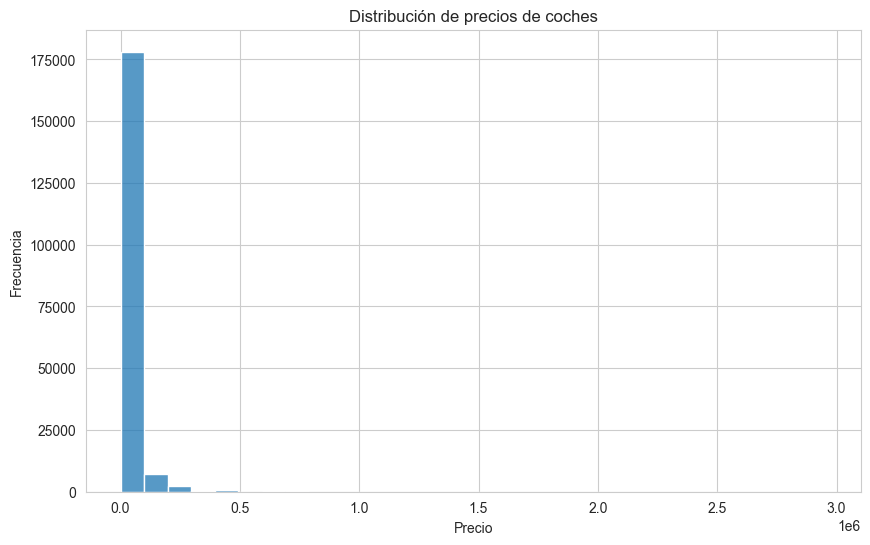

In [42]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_car_price, x='price', bins=30)
plt.title('Distribución de precios de coches')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

Hallazgos: Esperar a tratamiento de outliers

## 7. Análisis Bivariante
### 7.1 Correlaciones y Relaciones entre Variables

- Nos enfocamos específicamente en la relación entre la variable objetivo price.

- Creamos un mapa de calor para ver las relaciones entre las variables numéricas.

Index(['id', 'model_year', 'milage', 'price'], dtype='object')


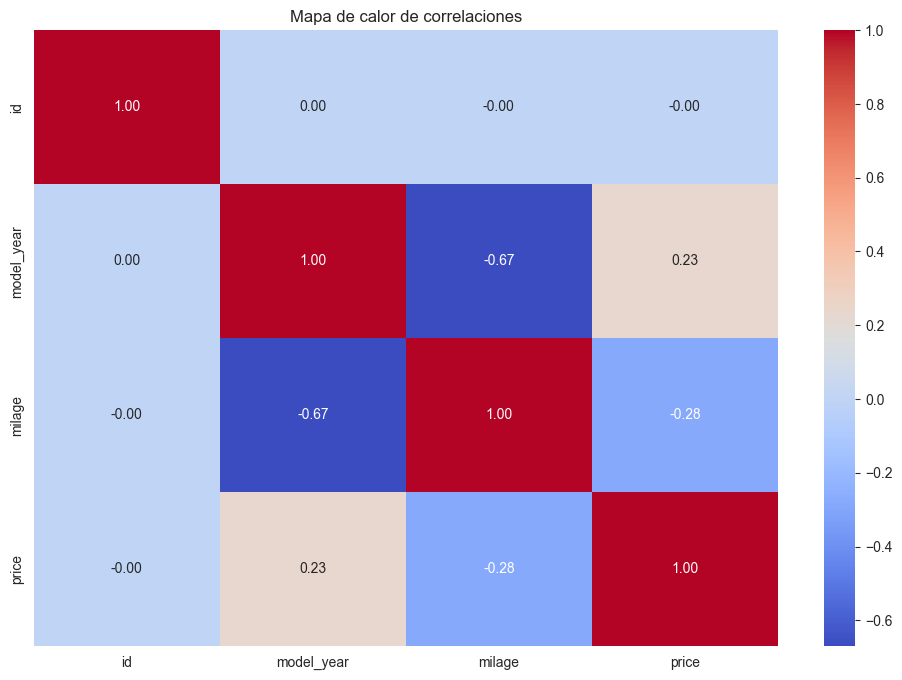

In [58]:
# Filtrar solo las columnas numéricas
numeric_columns = df_car_price.select_dtypes(include=['float64', 'int64'])
print(numeric_columns.columns)
# Calcular la matriz de correlación
correlation_matrix = numeric_columns.corr() 

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de calor de correlaciones")
plt.show()

Hallazgos:  
- En el análisis bivariado, se identificaron las variables model_year y milage como relevantes para predecir el precio (price). model_year muestra una correlación positiva moderada con price (0.23), indicando que los coches más nuevos tienden a tener precios más altos. Por otro lado, milage tiene una correlación negativa moderada con price (-0.28), lo que sugiere que los coches con mayor kilometraje suelen tener precios más bajos. Aunque estas variables tienen una correlación negativa fuerte entre sí (-0.67), ambas aportan información complementaria sobre la antigüedad y el uso del coche, siendo útiles para el modelo predictivo..

#### Gráfico de Dispersión
Para visualizar la relación entre price y cada variable relevante.

- Relación entre 'price' y 'model_year'

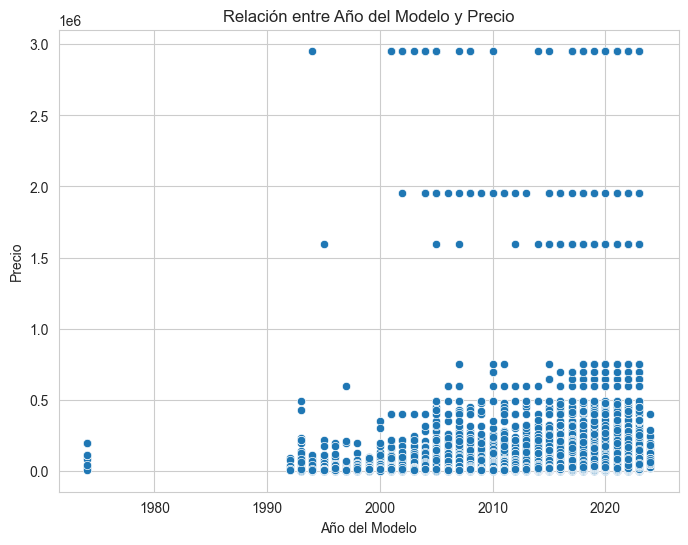

In [44]:

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_car_price, x='model_year', y='price')
plt.title('Relación entre Año del Modelo y Precio')
plt.xlabel('Año del Modelo')
plt.ylabel('Precio')
plt.show()

- Relación entre 'price' y 'milage'

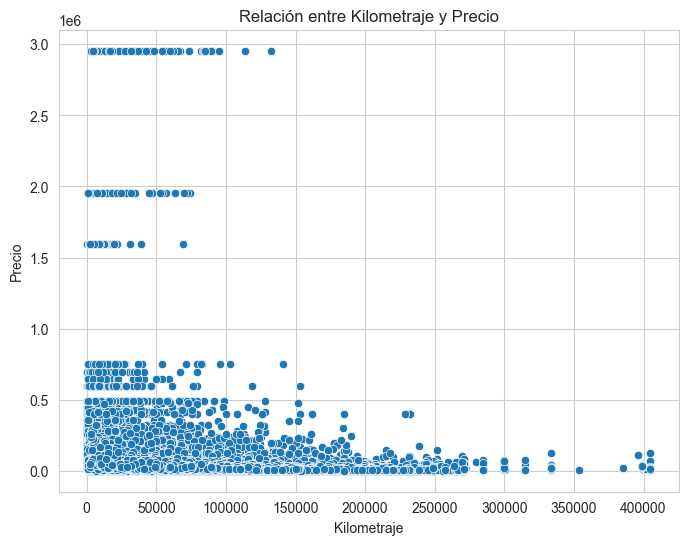

In [45]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_car_price, x='milage', y='price')
plt.title('Relación entre Kilometraje y Precio')
plt.xlabel('Kilometraje')
plt.ylabel('Precio')
plt.show()

#### Relación entre diferentes variables
- Creamos una función que genere gráficos de dispersión y calcule la correlación entre diabetes_prevalence y otras variables numéricas que deseemos analizar.

In [64]:
from sklearn.preprocessing import LabelEncoder

# Copiar el DataFrame original para no modificarlo directamente
df_encoded = df_car_price.copy()

# Codificar las columnas categóricas con LabelEncoder
label_encoder = LabelEncoder()
for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col].astype(str))

# Verificar las columnas codificadas
print(df_encoded.head())

   id  brand  model  model_year  milage  fuel_type  engine  transmission  ext_col  int_col  accident  clean_title  price
0   0     31    495        2007  213000          2     116            38      312       71         1            0   4200
1   1     28    930        2002  143250          2     366            38      263       10         0            0   4999
2   2      9   1575        2002  136731          1     640            38       38       71         1            0  13900
3   3     16    758        2017   19500          2     863            49       29       14         1            0  45000
4   4     36   1077        2021    7388          2     259            23       29       10         1            0  97500


Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')


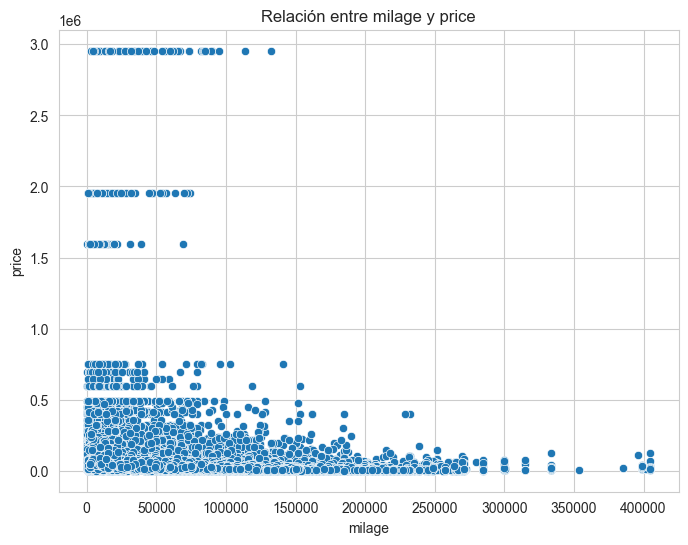

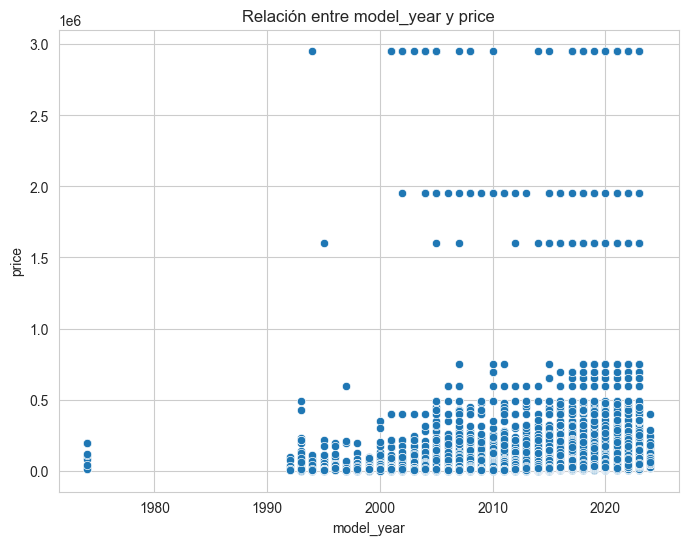

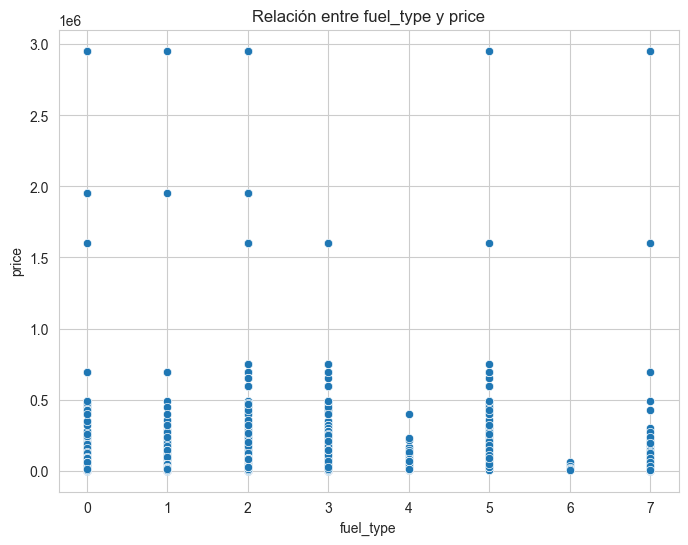

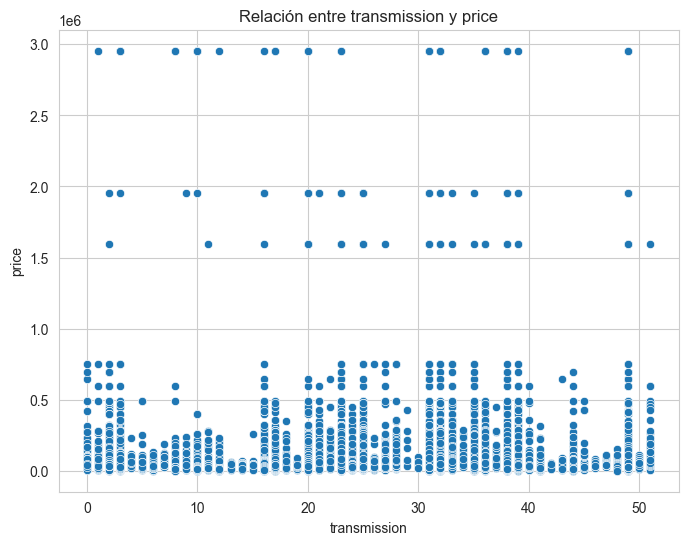

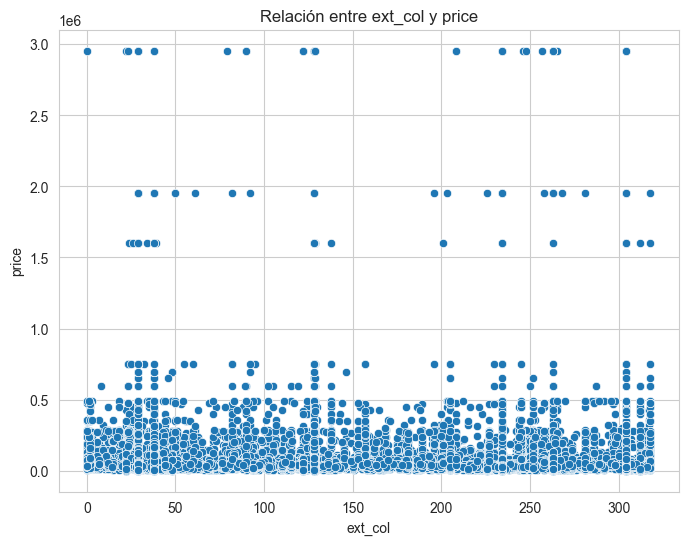

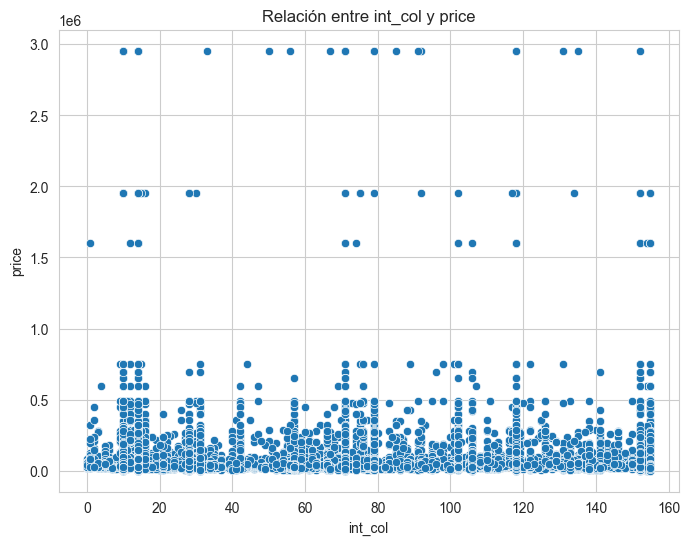

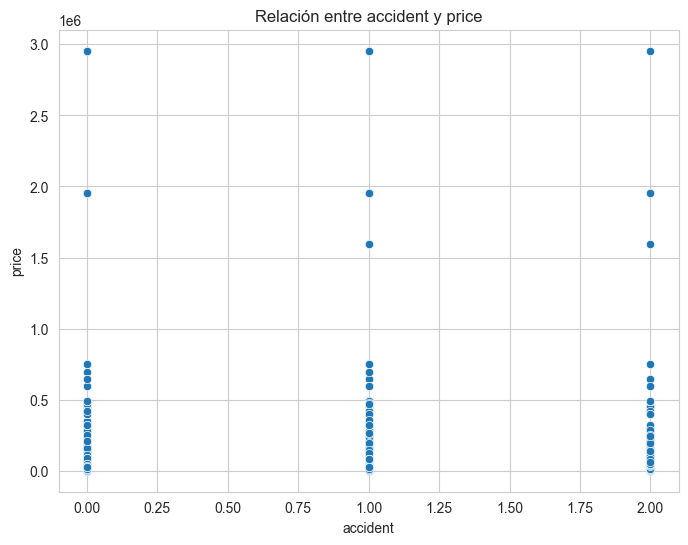

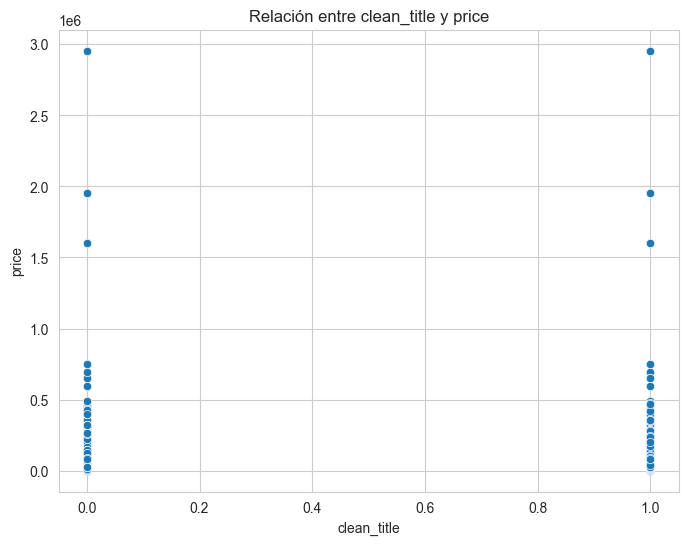

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Copiar el DataFrame original para no modificarlo directamente
df_encoded = df_car_price.copy()

# Codificar las columnas categóricas con LabelEncoder
label_encoder = LabelEncoder()
for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col].astype(str))

# Verificar las columnas disponibles
print(df_encoded.columns)

# Actualizar la lista de predictores con los nombres correctos
predictors = [
    'milage', 
    'model_year', 
    'fuel_type',  # Ahora es una columna numérica
    'transmission',  # Ahora es una columna numérica
    'ext_col',  # Ahora es una columna numérica
    'int_col',  # Ahora es una columna numérica
    'accident',  # Ahora es una columna numérica
    'clean_title'
]

import matplotlib.pyplot as plt
import seaborn as sns

# Definir la función analyze_relationship
def analyze_relationship(df, target, predictors):
    for predictor in predictors:
        if predictor in df.columns:
            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=df, x=predictor, y=target)
            plt.title(f'Relación entre {predictor} y {target}')
            plt.xlabel(predictor)
            plt.ylabel(target)
            plt.show()
        else:
            print(f"La columna '{predictor}' no está en el DataFrame.")

# Llamar a la función
analyze_relationship(df_encoded, target='price', predictors=predictors)

In [71]:
# def analyze_relationship(df, target, predictors):
#     for predictor in predictors:
#         # Calcular la correlación
#         correlation = df[target].corr(df[predictor])
#         print(f"Correlación entre {target} y {predictor}: {correlation:.2f}")
        
#         # Generar gráfico de dispersión
#         plt.figure(figsize=(8, 5))
#         sns.scatterplot(data=df, x=predictor, y=target)
#         plt.title(f"Relación entre {predictor} y {target} (Correlación: {correlation:.2f})")
#         plt.xlabel(predictor)
#         plt.ylabel(target)
#         plt.grid()
#         plt.show()

# # Filtrar las variables predictoras que existen en el DataFrame
# predictors = [
#     'milage', 
#     'model_year', 
#     'fuel_type_Diesel', 
#     'transmission_Manual', 
#     'ext_col_Black', 
#     'int_col_Gray', 
#     'accident_Yes', 
#     'clean_title'
# ]

# analyze_relationship(df_car_price, target='price', predictors=predictors)

# 8. Preprocesamiento de datos

- Codificación de variables categóricas (por ejemplo, LabelEncoder o pd.get_dummies).

# 9. Conclusión: